In [32]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [33]:
DATA_ROOT = Path('..') / 'data'

dfs = []
activity_labels = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activity_labels[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    
    # Add a column indicating order of the activities for a particiapnt.
    df = df.sort_values(by=['time'])
    df['activity_sequence'] = (df['activity'].shift(1) != df['activity']).cumsum()
    dfs.append(df)

sensor_df = pd.concat(dfs, axis='index')
sensor_df = sensor_df.sort_values(by=['participant', 'time'])

sensor_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,bed,M,d1p01M,1


### We need to get the length of consecutive sequences for each participant

#### Let's start with a single participant first!

In [89]:
mini = sensor_df[sensor_df['participant'] == 'd1p01M']

In [90]:
mini

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.42520,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.73690,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.03110,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.03710,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.89200,920.25,1,bed,M,d1p01M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,251.00,0.87003,0.46851,0.009122,4,-58.5,0.73631,921.75,1,bed,M,d1p01M,9
397,251.25,0.87003,0.46851,0.009122,1,-57.5,0.70870,923.25,1,bed,M,d1p01M,9
398,251.50,0.87003,0.46851,0.009122,1,-59.0,0.25157,924.75,1,bed,M,d1p01M,9
399,253.25,-0.00938,0.95081,-0.116310,1,-58.5,0.35282,924.25,1,bed,M,d1p01M,9


#### function for descriptives from a single participant

In [144]:
def count_datapoints(part):
    '''takes a dataframe and returns descriptives on datapoints and duration of each type of sequence
    code for grouping consecutive values into sequences adapted from here https://tinyurl.com/y6gab5fh'''
    
    p_data = []

    for _, v in mini.groupby((part['activity'].shift() != part['activity']).cumsum()):
        p_data.append([v.activity.unique()[0], len(v), round(v.time.iloc[-1] - v.time.iloc[0], 3)])
        
    p_df = pd.DataFrame(p_data, columns = ['activity_type', 'number_of_measurements', 'duration'])
    
    return p_df.groupby('activity_type')[['number_of_measurements','duration']].describe()

In [145]:
p = count_datapoints(mini)

In [146]:
p.head()

number_of_measurements                                          \
                               count   mean        std    min     25%    50%   
activity_type                                                                  
1                                4.0   28.5  26.236107    4.0    7.00   27.5   
2                                1.0   60.0        NaN   60.0   60.00   60.0   
3                                2.0  110.0   9.899495  103.0  106.50  110.0   
4                                2.0    3.5   0.707107    3.0    3.25    3.5   

                             duration                                     \
                  75%    max    count    mean        std    min      25%   
activity_type                                                              
1               49.00   55.0      4.0  17.270  17.656347   0.83   3.2075   
2               60.00   60.0      1.0  77.000        NaN  77.00  77.0000   
3              113.50  117.0      2.0  41.875   7.601398  36.50  39.1875   
4                3.75    4.0      2.0   5.625   2.651650   3.75   4.6875   

                                       
                  50%      75%    max  
activity_type                          
1              15.625  29.6875  37.00  
2              77.000  77.0000  77.00  
3              41.875  44.5625  47.25  
4               5.625   6.5625   7.50

#### now let's apply this to *all participants*

In [147]:
desc_df = sensor_df.groupby('participant').apply(count_datapoints)


In [148]:
desc_df

number_of_measurements                         \
                                           count        mean        std   
participant activity_type                                                 
d1p01M      1                                4.0   28.500000  26.236107   
            2                                1.0   60.000000        NaN   
            3                                2.0  110.000000   9.899495   
            4                                2.0    3.500000   0.707107   
d1p02M      1                                6.0   31.000000  24.576411   
...                                          ...         ...        ...   
d2p26F      1                                9.0   22.111111  28.576408   
            2                                1.0    1.000000        NaN   
            3                                3.0   10.333333   6.429101   
d2p27F      1                                6.0   16.000000  15.019987   
            3                                6.0   13.666667   9.993331   

                                                               duration  \
                             min     25%    50%     75%    max    count   
participant activity_type                                                 
d1p01M      1                4.0    7.00   27.5   49.00   55.0      4.0   
            2               60.0   60.00   60.0   60.00   60.0      1.0   
            3              103.0  106.50  110.0  113.50  117.0      2.0   
            4                3.0    3.25    3.5    3.75    4.0      2.0   
d1p02M      1                2.0   11.25   37.5   39.75   66.0      6.0   
...                          ...     ...    ...     ...    ...      ...   
d2p26F      1                3.0    9.00   12.0   14.00   95.0      9.0   
            2                1.0    1.00    1.0    1.00    1.0      1.0   
            3                3.0    8.00   13.0   14.00   15.0      3.0   
d2p27F      1                3.0    8.25   11.5   16.25   45.0      6.0   
            3                4.0    8.00   11.0   15.50   32.0      6.0   

                                                                          \
                                mean        std    min       25%     50%   
participant activity_type                                                  
d1p01M      1              17.270000  17.656347   0.83   3.20750  15.625   
            2              77.000000        NaN  77.00  77.00000  77.000   
            3              41.875000   7.601398  36.50  39.18750  41.875   
            4               5.625000   2.651650   3.75   4.68750   5.625   
d1p02M      1              20.958333  18.272532   0.50   6.68750  24.375   
...                              ...        ...    ...       ...     ...   
d2p26F      1              12.594444  12.908535   1.50   4.25000   8.000   
            2               0.000000        NaN   0.00   0.00000   0.000   
            3               3.516667   2.316022   0.85   2.76250   4.675   
d2p27F      1               7.791667   5.249802   0.50   4.50000   8.000   
            3               4.420833   3.725199   1.40   2.13125   3.675   

                                            
                               75%     max  
participant activity_type                   
d1p01M      1              29.6875  37.000  
            2              77.0000  77.000  
            3              44.5625  47.250  
            4               6.5625   7.500  
d1p02M      1              25.9375  49.250  
...                            ...     ...  
d2p26F      1              10.2500  37.750  
            2               0.0000   0.000  
            3               4.8500   5.025  
d2p27F      1              11.1250  14.750  
            3               4.3375  11.600  

[175 rows x 16 columns]

### Quickest way to get a sense of what's going on with the data is still by plotting

#### let's plot first by sequences overall, then break these down by participants too

What's the distribution of counts of sequences for all participants? 

<AxesSubplot:>

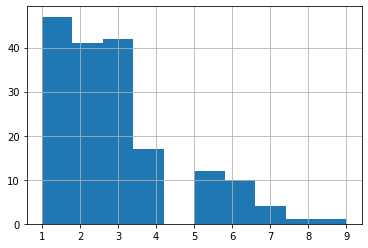

In [43]:
desc_df['number_of_measurements']['count'].hist()

couple of checks on the histogram

what's the maximal number of same sequence in participants? 

In [44]:
desc_df['number_of_measurements']['count'].max()

9.0

##### Easier to have participant and activity_type as columns..

In [120]:
desc_df.reset_index(inplace=True)

In [122]:
desc_df

participant activity_type number_of_measurements                         \
                                               count        mean        std   
0        d1p01M             1                    4.0   28.500000  26.236107   
1        d1p01M             2                    1.0   60.000000        NaN   
2        d1p01M             3                    2.0  110.000000   9.899495   
3        d1p01M             4                    2.0    3.500000   0.707107   
4        d1p02M             1                    6.0   31.000000  24.576411   
..          ...           ...                    ...         ...        ...   
170      d2p26F             1                    9.0   22.111111  28.576408   
171      d2p26F             2                    1.0    1.000000        NaN   
172      d2p26F             3                    3.0   10.333333   6.429101   
173      d2p27F             1                    6.0   16.000000  15.019987   
174      d2p27F             3                    6.0   13.666667   9.993331   

                                         duration                        \
       min     25%    50%     75%    max    count       mean        std   
0      4.0    7.00   27.5   49.00   55.0      4.0  17.270000  17.656347   
1     60.0   60.00   60.0   60.00   60.0      1.0  77.000000        NaN   
2    103.0  106.50  110.0  113.50  117.0      2.0  41.875000   7.601398   
3      3.0    3.25    3.5    3.75    4.0      2.0   5.625000   2.651650   
4      2.0   11.25   37.5   39.75   66.0      6.0  20.958333  18.272532   
..     ...     ...    ...     ...    ...      ...        ...        ...   
170    3.0    9.00   12.0   14.00   95.0      9.0  12.594444  12.908535   
171    1.0    1.00    1.0    1.00    1.0      1.0   0.000000        NaN   
172    3.0    8.00   13.0   14.00   15.0      3.0   3.516667   2.316022   
173    3.0    8.25   11.5   16.25   45.0      6.0   7.791667   5.249802   
174    4.0    8.00   11.0   15.50   32.0      6.0   4.420833   3.725199   

                                               
       min       25%     50%      75%     max  
0     0.83   3.20750  15.625  29.6875  37.000  
1    77.00  77.00000  77.000  77.0000  77.000  
2    36.50  39.18750  41.875  44.5625  47.250  
3     3.75   4.68750   5.625   6.5625   7.500  
4     0.50   6.68750  24.375  25.9375  49.250  
..     ...       ...     ...      ...     ...  
170   1.50   4.25000   8.000  10.2500  37.750  
171   0.00   0.00000   0.000   0.0000   0.000  
172   0.85   2.76250   4.675   4.8500   5.025  
173   0.50   4.50000   8.000  11.1250  14.750  
174   1.40   2.13125   3.675   4.3375  11.600  

[175 rows x 18 columns]

<AxesSubplot:>

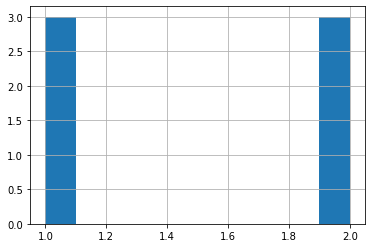